# Example of Value iteration

We will work out an example of the policy iteration algorithm on the Frozen Lake gym env

</b> https://gym.openai.com/envs/FrozenLake-v0/

## 1) Environment breakdown

In [1]:
import numpy as np
import gym
from gym.envs.registration import register

# make a non-slippery version of Frozen lake
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78, # optimum = .8196
)

In [2]:
# create environment
env = gym.make("FrozenLakeNotSlippery-v0")

# make sure it is the correct format
if type(env) == gym.wrappers.time_limit.TimeLimit:
    env = env.unwrapped

In [3]:
env.nS # Get the number of states
env.nA # Get the number of actions

print('Environment has %d states and %d actions.' % (env.nS, env.nA))

Environment has 16 states and 4 actions.


In [4]:
# display env
env.render()


SFFF
FHFH
FFFH
HFFG


In [5]:
# The actions referrence
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

In [6]:
# The environment dynamics, represented as a dictionary of dictionaries
# getting the info for P(.|s,a)
state = 0 
action = LEFT
env.P[state][action] # returns the [(P(s'|s, a), s', reward, is_terminal), ... ] 

[(1.0, 0, 0.0, False)]

## 2) What we need to do
Find a policy $\pi(a|s)$, which is a conditional probability distribution that describes how we should act in the environment

In [7]:
# Example: Uniform random policy
policy = np.ones([env.nS, env.nA]) / env.nA
policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

Demonstration of running this policy in the environment

In [8]:
def run_policy(env, policy):
    '''
    Function for running a policy on an environment.
    Its just a way to visualize what you policy is doing in the env
    '''
    # initialize the env
    state = env.reset()
    env.render()
    print("\n ------ \n")
    
    total_reward = 0
    num_steps = 0
    # iterate through the environment until termination
    while True:
        
        action = np.random.choice(env.nA, 1, p = policy[state])[0] # sample an action from your policy
        next_state, reward, is_terminal, _ = env.step(action) # use that action on the env and get info back
    
        env.render()
        print("\n ------ \n")
        
        state = next_state
        
        total_reward += reward
        num_steps += 1

        if is_terminal:
            break
    
    print("The episode ended after {0} steps with a total reward of {1}".format(num_steps, total_reward))

In [45]:
run_policy(env, policy)


SFFF
FHFH
FFFH
HFFG

 ------ 

  (Left)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Left)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Up)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Down)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Down)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Down)
SFFF
FHFH
FFFH
HFFG

 ------ 

The episode ended after 6 steps with a total reward of 0.0


## 3) Policy Evaluation

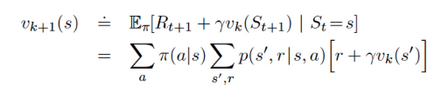

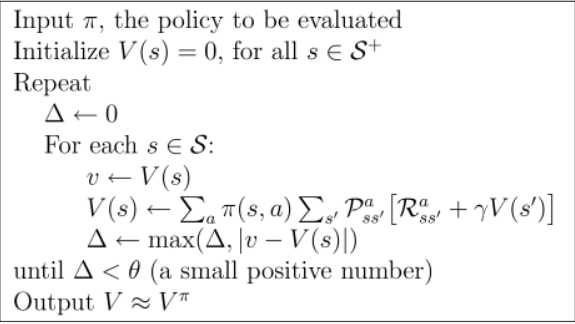

In [9]:
def policy_evaluation(env, policy, discount = 1.0, epsilon = 10 ** -8):
    
    V = np.zeros(env.nS) # initialize the states to zero
    
    while(True):
        
        delta = 0
        
        for state in range(env.nS):
            
            v_old = V[state]
            
            sum = 0
            for action, action_prob in enumerate(policy[state]):
                
                for state_prob, next_state, reward, end in env.P[state][action]:
                    sum += action_prob * state_prob * (reward + discount * V[next_state])
            
            V[state] = sum
            delta = max(delta, np.abs(V[state] - v_old))
            
        if delta < epsilon: return V
            

In [10]:
# random policy evaluation
V = policy_evaluation(env, policy, discount = 0.9)
V

array([0.00447724, 0.00422245, 0.01006675, 0.00411821, 0.00672195,
       0.        , 0.02633371, 0.        , 0.01867615, 0.05760701,
       0.10697195, 0.        , 0.        , 0.13038305, 0.39149016,
       0.        ])

## 4) Policy Improvement

First lets talk about action values

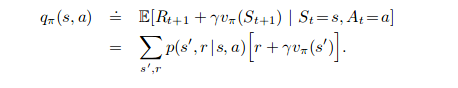

In [11]:
def get_q_values(env, state, V, discount = 1):
    '''
    Function to return the all the action values of the form Q(s,a) for a given state s. 
    '''
    action_values = np.zeros(env.nA)
    
    for action in range(env.nA):
        
        for prob, next_state, reward, done in env.P[state][action]:
            
            action_values[action] += prob * (reward + discount * V[next_state])
            
    return action_values

Policy imporvement is just being greedy

In [12]:
def policy_improvement(env, policy, V, discount = 1.0):
    
    for state in range(env.nS):
        
        action_values = get_q_values(env, state, V, discount = discount) # get the q values associated to state s
        best_action = np.argmax(action_values) # choose best action
        
        policy[state] = np.eye(env.nA)[best_action] # greedy update of policy
        
    return policy

## 5) Policy iteration

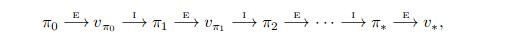

In [13]:
def policy_iteration(env, discount = 1.0):
    
    policy = np.ones([env.nS, env.nA]) / env.nA # create a random uniform policy
    
    while True:
        
        old_policy = policy
        
        V = policy_evaluation(env, policy, discount = discount) # evaluate the policy
        policy = policy_improvement(env, policy, V, discount = discount) # improve it
        
        # stop when the policy doesn't change anymore. Use each the optimal policy
        if np.array_equal(old_policy, policy):
            break
            
    return policy

In [14]:
env.reset()
opt_policy = policy_iteration(env, discount = 0.9)

In [15]:
# Recall
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

opt_policy

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [16]:
env.render()


SFFF
FHFH
FFFH
HFFG


In [17]:
# run the optimal policy
run_policy(env, opt_policy)


SFFF
FHFH
FFFH
HFFG

 ------ 

  (Down)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Down)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Right)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Down)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Right)
SFFF
FHFH
FFFH
HFFG

 ------ 

  (Right)
SFFF
FHFH
FFFH
HFFG

 ------ 

The episode ended after 6 steps with a total reward of 1.0


## Additional Resources and References

</br> Images and pseudo code was taken from Reinforcement Learning an Introduction, R.Sutton and A. Barto: http://incompleteideas.net/book/RLbook2018.pdf

</br> https://www.analyticsvidhya.com/blog/2018/09/reinforcement-learning-model-based-planning-dynamic-programming/ (blog post that talks about the same thing)

</br> https://www.youtube.com/watch?v=5R2vErZn0yw (youtube video that does walk through of the same thing)